In [1]:
import tensorflow as tf
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from keras.callbacks import EarlyStopping

import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

In [2]:
%load_ext tensorboard

In [3]:
image_size = 224
batch_size = 16

In [4]:
train_folder = "../../datasets/data_vipr/masked_3/train"
test_folder = "../../datasets/data_vipr/masked_3/test"

In [5]:
dataset= tf.keras.utils.image_dataset_from_directory(
  "../../datasets/data_vipr/masked_3/train",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 17117 files belonging to 5 classes.


In [6]:
train_datagen = ImageDataGenerator(
   rescale=1./255,
   shear_range=0.2,
   zoom_range=0.2,
   horizontal_flip=True
)

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
   train_folder,
   target_size=(image_size, image_size),
   batch_size=batch_size,
   class_mode='categorical',
   color_mode='rgb',
   shuffle=True
)

Found 17117 images belonging to 5 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(
   test_folder,
   target_size=(image_size, image_size),
   batch_size=batch_size,
   class_mode='categorical',
   color_mode='rgb'
)

Found 4280 images belonging to 5 classes.


In [10]:
class_names = dataset.class_names
print(class_names)

['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']


In [11]:
base_model = tf.keras.applications.EfficientNetV2S(
   weights='imagenet',
   input_shape=(image_size, image_size, 3),
   include_top=False
)

In [12]:
base_model.trainable = True

In [13]:
model = tf.keras.Sequential([
   base_model,
   layers.GlobalAveragePooling2D(),
   layers.Dense(1024, activation='relu'),
   layers.Dropout(0.5),
   layers.Dense(len(class_names), activation='softmax'),
])

In [14]:
from tensorflow.keras.optimizers import Adam
adam_opt = Adam(learning_rate=0.0001)

model.compile(
   optimizer=adam_opt,
   loss='categorical_crossentropy',
   metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 21,648,229
Trainable params: 21,494,357
No

In [16]:
epochs = 100

In [17]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [18]:
history = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
  callbacks=[
    tensorboard_callback,
    EarlyStopping(monitor='val_loss', patience=10)
  ]
)

Epoch 1/100
1070/1070 [==============================] - 279s 239ms/step - loss: 0.6707 - accuracy: 0.7534 - val_loss: 0.4531 - val_accuracy: 0.8421
Epoch 2/100
1070/1070 [==============================] - 195s 182ms/step - loss: 0.4632 - accuracy: 0.8344 - val_loss: 0.4072 - val_accuracy: 0.8589
Epoch 3/100
1070/1070 [==============================] - 192s 180ms/step - loss: 0.3804 - accuracy: 0.8655 - val_loss: 0.3737 - val_accuracy: 0.8657
Epoch 4/100
1070/1070 [==============================] - 191s 179ms/step - loss: 0.3297 - accuracy: 0.8814 - val_loss: 0.3848 - val_accuracy: 0.8692
Epoch 5/100
1070/1070 [==============================] - 195s 182ms/step - loss: 0.2698 - accuracy: 0.9042 - val_loss: 0.4033 - val_accuracy: 0.8664
Epoch 6/100
1070/1070 [==============================] - 191s 179ms/step - loss: 0.2286 - accuracy: 0.9179 - val_loss: 0.4116 - val_accuracy: 0.8696
Epoch 7/100
1070/1070 [==============================] - 191s 178ms/step - loss: 0.1988 - accuracy: 0.9293

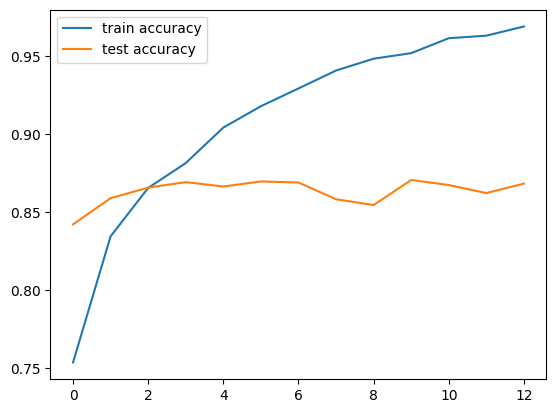

In [19]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.legend()
plt.show()

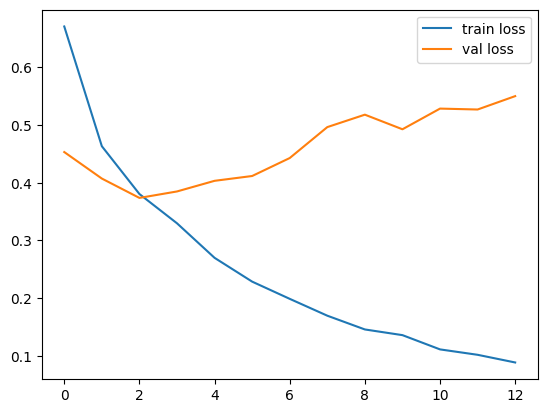

In [20]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

In [ ]:
%tensorboard --logdir logs/fit